In [9]:
import Ipynb_importer
# %load utils.py
import os
import time
import math
import torch
import random
import logging
import librosa
import argparse
import pescador
import numpy as np
from config import *
from torch import autograd
from torch.autograd import Variable
import matplotlib
#matplotlib.use('agg')
import matplotlib.pyplot as plt
import soundfile as sf
import csv
from scipy import signal

LOGGER = logging.getLogger('specgan')
LOGGER.setLevel(logging.DEBUG)

freqs = 360000

def make_path(output_path):
    if not os.path.isdir(output_path):
        os.makedirs(output_path)
    return output_path

traindata = DATASET_NAME
output = make_path(OUTPUT_PATH)

def time_since(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)


        
def save_and_plot( t, f, epoch_samples, epoch, output_dir): # 10,2,128,128
    """
    Save output samples.
    """
    sample_dir = make_path(os.path.join(output_dir, str(epoch))) 
    fs = freqs
    # save_timeseries
    data = []
    fn = sample_dir + '/' + str(epoch) + "times_tocsv.csv"
    with open(fn,'w',newline='') as csvFile:
        csvWriter = csv.writer(csvFile)
        for i in range(len(epoch_samples)):
            csvWriter.writerow( spectrogram_to_time(epoch_samples[i])[1] )   # [1] is really signal
            data.append( spectrogram_to_time(epoch_samples[i])[1] )
    
    # plot spectrogram
    cm=plt.cm.get_cmap('rainbow') 
    plt.figure(figsize=(30,10))

    plt.pcolormesh(t, f, epoch_samples[0][0],cmap=cm)
    plt.savefig(sample_dir + '/' + str(epoch) + "spectrogram_0.png") 
    
    plt.clf()
    for i in range(len(epoch_samples)):
        plt.subplot(2, 5, i+1)
        plt.pcolormesh(t, f, epoch_samples[i][0],cmap=cm)
    plt.savefig(sample_dir + '/' + str(epoch) + "spectrogram.png") # put this command forward show
    
    # plot time series
    plt.clf()
    l = len(data[0])
    plt.plot(np.arange(0,l/fs,1/fs),data[0])
    plt.savefig(sample_dir + '/' + str(epoch) + "timeseries_0.png")
    
    plt.clf()
    for i in range(len(data)):
        plt.subplot(2, 5, i+1)
        plt.plot(np.arange(0,l/fs,1/fs),data[i])
    plt.savefig(sample_dir + '/' + str(epoch) + "timeseries.png") # put this command forward show
    
    plt.cla()
    plt.close("all")
    return sample_dir

    
    

#### signal processing ####
# Based on https://github.com/librosa/librosa/issues/434

def _stft_forgriffin(y):
    f, t, Zxx = signal.stft(y, fs=freqs, nperseg=257, noverlap=128)
    return Zxx

def _griffin_lim(S):
    m = np.mean(S,axis=0)
    S = np.vstack((m,S))
    angles = np.exp(2j * np.pi * np.random.rand(*S.shape)) # S.shape = (128*128)
    S_complex = np.abs(S).astype(np.complex)
    for i in range(griffin_lim_iters):
        if i > 0:
            angles = np.exp(1j * np.angle(_stft_forgriffin(y[1])))
        y = _istft(S_complex * angles)
    return y

def _istft(S):
    return signal.istft(S, fs=freqs, nperseg=257, noverlap=128)

# spectrogram to time
def spectrogram_to_time(spectrogram): # 2,128,128
    # abs
    minva = -4
    lownum = 1e-8
    Zxx2denor = spectrogram[0]*abs(minva) + minva
    Zxx2dbtoamp = np.power(10,Zxx2denor)- lownum
    m = np.mean(Zxx2dbtoamp,axis=0)
    Zxx2dbtoamp = np.vstack((m,Zxx2dbtoamp))
    
    # phase
    finetuneangle = 3.15
    phase = spectrogram[1] * finetuneangle 
    m = np.mean(phase,axis=0)
    phase = np.vstack((m,phase))
    
    # estimate 
    estimate = _istft( Zxx2dbtoamp * np.exp(1j*phase) )
    
    return estimate 

# time to spectrogram
def time_to_mixabsphase(time_series):
    fs = freqs
    f, t, Zxx = signal.stft(time_series, fs=fs, nperseg=257, noverlap=128)
    f = f[1:]
    Zxx = Zxx[1:]
    
    # handle abs 
    lownum = 1e-8
    Zxx2 = abs(Zxx) + lownum
    Zxx2log = np.log10(Zxx2)
    minva = -4
    Zxx2nor = ( Zxx2log - (minva) )/abs(minva)
    Zxx2nor = Zxx2nor[np.newaxis,:,:]
    
    # handle the angle
    phase = np.angle(Zxx)
    finetuneangle = 3.15
    tophase = phase / finetuneangle
    tophase = tophase[np.newaxis,:,:]
    
    return np.vstack((Zxx2nor,tophase))

# Adapted from @jtcramer https://github.com/jtcramer/wavegan/blob/master/sample.py.
def sample_generator(data, window_length=16384, fs=freqs):
    """
    Audio sample generator
    """
    # Pad audio to >= window_length.
    audio_len = len(data)

    while True:
        # signal processing
        sample = data
        X_norm = time_to_mixabsphase(sample)  
        X_norm = X_norm.astype('float32')  
        
        assert not np.any(np.isnan(X_norm))

        yield {'X': X_norm}

def batch_generator(datas, batch_size):
    streamers = []
    for i in range(len(datas)):
        s = pescador.Streamer(sample_generator, datas[i])
        streamers.append(s)
    mux = pescador.ShuffledMux(streamers)
    batch_gen = pescador.buffer_stream(mux, batch_size)

    return batch_gen


def get_all_audio_filepaths(audio_dir):
    return [os.path.join(root, fname)
            for (root, dir_names, file_names) in os.walk(audio_dir, followlinks=True)
            for fname in file_names
            if (fname.lower().endswith('.wav') or fname.lower().endswith('.mp3'))]


def split_data(audio_path_list, valid_ratio, test_ratio, batch_size):
    num_files = len(audio_path_list)
    num_valid = int(np.ceil(num_files * valid_ratio))
    num_test = int(np.ceil(num_files * test_ratio))
    num_train = num_files - num_valid - num_test

    if not (num_valid > 0 and num_test > 0 and num_train > 0):
        LOGGER.error("Please download DATASET '{}' and put it under current path !".format(DATASET_NAME))

    # Random shuffle the audio_path_list for splitting.
    random.shuffle(audio_path_list)

    valid_files = audio_path_list[:num_valid]
    test_files = audio_path_list[num_valid:num_valid + num_test]
    train_files = audio_path_list[num_valid + num_test:]
    train_size = len(train_files)


    train_data = batch_generator(train_files, batch_size)
    valid_data = batch_generator(valid_files, batch_size)
    test_data = batch_generator(test_files, batch_size)

    return train_data, valid_data, test_data, train_size   





def numpy_to_var(numpy_data, cuda):
    """
    Convert numpy array to Variable.
    """
#     data = numpy_data[:, np.newaxis, : , :]
    data = torch.Tensor(numpy_data)
    if cuda:
        data = data.cuda()
    return Variable(data, requires_grad=False)
        

    
# Adapted from https://github.com/caogang/wgan-gp/blob/master/gan_toy.py
def calc_gradient_penalty(net_dis, real_data, fake_data, batch_size, lmbda, use_cuda=False):
    # Compute interpolation factors
    alpha = torch.rand(batch_size, 2 , 1 , 1)
    alpha = alpha.expand(real_data.size()) 
    alpha = alpha.cuda() if use_cuda else alpha

    # Interpolate between real and fake data.
    interpolates = alpha * real_data + (1 - alpha) * fake_data # batch * num_channel * 128*128
    if use_cuda:
        interpolates = interpolates.cuda()
    interpolates = autograd.Variable(interpolates, requires_grad=True)

    # Evaluate discriminator
    disc_interpolates = net_dis(interpolates) 

    # Obtain gradients of the discriminator with respect to the inputs
    gradients = autograd.grad(outputs=disc_interpolates, inputs=interpolates, 
                              grad_outputs=torch.ones(disc_interpolates.size()).cuda() if use_cuda else
                              torch.ones(disc_interpolates.size()),
                              create_graph=True, retain_graph=True, only_inputs=True)[0] # batch 2 128 128
    
    gradients = gradients.view(gradients.size(0), 2 , 128 , -1)

    # Compute MSE between 1.0 and the gradient of the norm penalty to make discriminator
    # to be a 1-Lipschitz function.
    gradient_penalty = lmbda * ( ( gradients.norm(2, dim=(2,3) ) - 1) ** 2 ).mean()
    return gradient_penalty   

def plot_loss(D_cost_train, D_wass_train, D_cost_valid, D_wass_valid,
              G_cost, save_path):
    assert len(D_cost_train) == len(D_wass_train) == len(D_cost_valid) == len(D_wass_valid) == len(G_cost)

    save_path = os.path.join(save_path, "loss_curve.png")

    x = range(len(D_cost_train))

    y1 = D_cost_train
    y2 = D_wass_train
    y3 = D_cost_valid
    y4 = D_wass_valid
    y5 = G_cost

    plt.plot(x, y1, label='D_loss_train')
    plt.plot(x, y2, label='D_wass_train')
    plt.plot(x, y3, label='D_loss_valid')
    plt.plot(x, y4, label='D_wass_valid')
    plt.plot(x, y5, label='G_loss')

    plt.xlabel('Epoch')
    plt.ylabel('Loss')

    plt.legend(loc=4)
    plt.grid(True)
    plt.tight_layout()

    plt.savefig(save_path)
    
    


def parse_arguments():
    """
    Get command line arguments
    """
    parser = argparse.ArgumentParser(description='Train a WaveGAN on a given set of audio')

    parser.add_argument('-ms', '--model-size', dest='model_size', type=int, default=64,
                        help='Model size parameter used in WaveGAN')
    parser.add_argument('-pssf', '--phase-shuffle-shift-factor', dest='shift_factor', type=int, default=2,
                        help='Maximum shift used by phase shuffle')
    parser.add_argument('-psb', '--phase-shuffle-batchwise', dest='batch_shuffle', action='store_true',
                        help='If true, apply phase shuffle to entire batches rather than individual samples')
    parser.add_argument('-ppfl', '--post-proc-filt-len', dest='post_proc_filt_len', type=int, default=512,
                        help='Length of post processing filter used by generator. Set to 0 to disable.')
    parser.add_argument('-lra', '--lrelu-alpha', dest='alpha', type=float, default=0.2,
                        help='Slope of negative part of LReLU used by discriminator')
    parser.add_argument('-vr', '--valid-ratio', dest='valid_ratio', type=float, default=0.1,
                        help='Ratio of audio files used for validation')
    parser.add_argument('-tr', '--test-ratio', dest='test_ratio', type=float, default=0.1,
                        help='Ratio of audio files used for testing')
    parser.add_argument('-bs', '--batch-size', dest='batch_size', type=int, default=BATCH_SIZE,
                        help='Batch size used for training')
    parser.add_argument('-ne', '--num-epochs', dest='num_epochs', type=int, default=EPOCHS, help='Number of epochs')
    parser.add_argument('-ng', '--ngpus', dest='ngpus', type=int, default=4,
                        help='Number of GPUs to use for training')
    parser.add_argument('-ld', '--latent-dim', dest='latent_dim', type=int, default=100,
                        help='Size of latent dimension used by generator')
    parser.add_argument('-eps', '--epochs-per-sample', dest='epochs_per_sample', type=int, default=SAMPLE_EVERY,
                        help='How many epochs between every set of samples generated for inspection')
    parser.add_argument('-ss', '--sample-size', dest='sample_size', type=int, default=SAMPLE_NUM,
                        help='Number of inspection samples generated')
    parser.add_argument('-rf', '--regularization-factor', dest='lmbda', type=float, default=10.0,
                        help='Gradient penalty regularization factor')
    parser.add_argument('-lr', '--learning-rate', dest='learning_rate', type=float, default=1e-4,
                        help='Initial ADAM learning rate')
    parser.add_argument('-bo', '--beta-one', dest='beta1', type=float, default=0.5, help='beta_1 ADAM parameter')
    parser.add_argument('-bt', '--beta-two', dest='beta2', type=float, default=0.9, help='beta_2 ADAM parameter')
    parser.add_argument('-v', '--verbose', dest='verbose', action='store_true')
    parser.add_argument('-audio_dir', '--audio_dir', dest='audio_dir', type=str, default=traindata, help='Path to directory containing audio files')
    parser.add_argument('-output_dir', '--output_dir', dest='output_dir', type=str, default=output, help='Path to directory where model files will be output')
    args = parser.parse_args(args=[])
    return vars(args)

In [10]:
# #load cyclcos data
# import csv
# import numpy as np
# datas = []
# with open('firstdata.csv', newline='') as csvfile:
# #with open('cyclo2.csv', newline='') as csvfile:
#     rows = csv.reader(csvfile)
#     for row in rows:
#         datas.append( list( map(float,row) ) )
#     csvfile.close()
# datas = np.array(datas)
# print(datas.shape)

(10, 16384)


In [13]:
# a = time_to_mixabsphase(datas[0])
# print(a.shape)
# b = np.array(spectrogram_to_time(a))
# print(b.shape)
# print(b[1])

(2, 128, 128)
(2, 16384)
[ 0.03716031  0.01692119 -0.02899462 ... -0.00908226 -0.03975782
 -0.05044547]


DescribeResult(nobs=16384, minmax=(-0.595906742215111, 0.70400979686242), mean=0.00020767581989550223, variance=0.0017512566274504493, skewness=1.0297271747848025, kurtosis=57.24816473795018)


Text(0, 0.5, 'Amp')

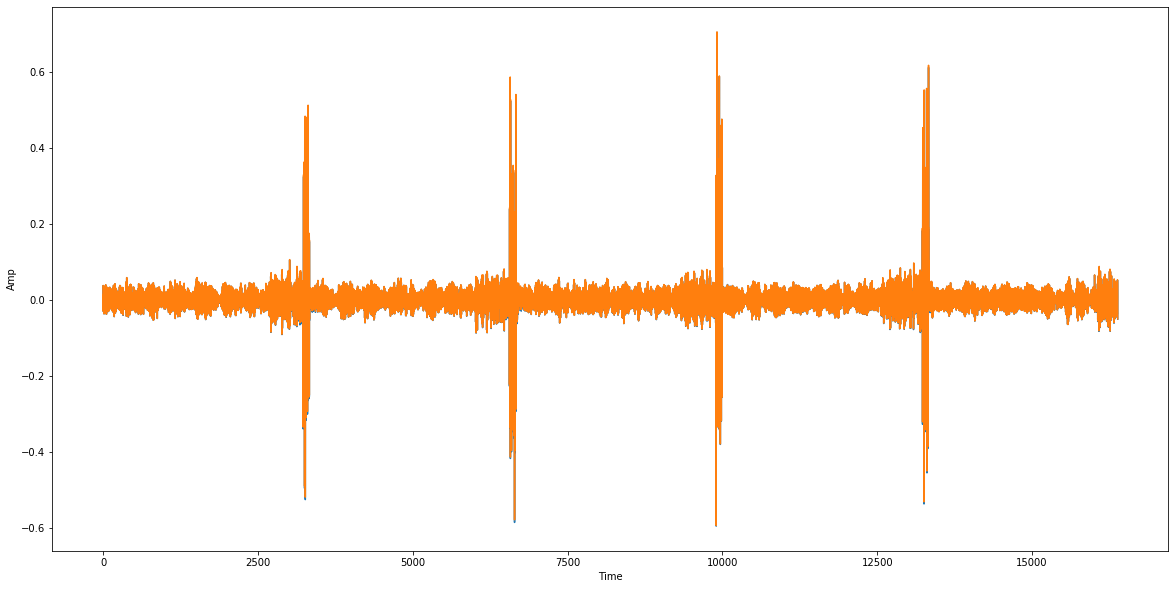

In [14]:
# # signal
# import matplotlib.pyplot as plt
# from scipy import stats
# print( stats.describe(datas[0]) )
# fs = 360000 #360k
# plt.figure(figsize=(20,10))
# plt.plot(datas[0])
# plt.plot(b[1])
# plt.xlabel("Time")
# plt.ylabel("Amp")

In [1]:
import numpy as np
np.angle()

C:\Users\UJ\Anaconda3\envs\pytorch\lib\site-packages\numpy\__init__.py:143: UserWarning: mkl-service package failed to import, therefore Intel(R) MKL initialization ensuring its correct out-of-the box operation under condition when Gnu OpenMP had already been loaded by Python process is not assured. Please install mkl-service package, see http://github.com/IntelPython/mkl-service
  from . import _distributor_init


ImportError: 

IMPORTANT: PLEASE READ THIS FOR ADVICE ON HOW TO SOLVE THIS ISSUE!

Importing the numpy C-extensions failed. This error can happen for
many reasons, often due to issues with your setup or how NumPy was
installed.

We have compiled some common reasons and troubleshooting tips at:

    https://numpy.org/devdocs/user/troubleshooting-importerror.html

Please note and check the following:

  * The Python version is: Python3.7 from "C:\Users\UJ\Anaconda3\envs\pytorch\python.exe"
  * The NumPy version is: "1.20.3"

and make sure that they are the versions you expect.
Please carefully study the documentation linked above for further help.

Original error was: DLL load failed: 找不到指定的模組。
